# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
!pip uninstall numpy -y

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [4]:
!pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 102.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


**Note:** A pop-up will appear prompting you to restart the session. Please click on it, and then begin running the notebook from the cell below — not from the beginning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2611325 sha256=c2fb696ece420e5572429374fdacdcd8456a28eda380da8dcce6e67fc3e5b20d
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
import pandas as pd

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [5]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', names=['user_id', 'prod_id', 'rating', 'timestamp'])

# Drop the timestamp column
data.drop('timestamp', axis=1, inplace=True)

# Copy the data to another DataFrame for further processing
df = data.copy()

# Display the first few rows
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
# Shape of the data
print("Shape of the dataset:", df_final.shape)


Shape of the dataset: (65290, 3)


**Observations**
1. __Shape of the dataset:__\
   The filtered dataset contains __65,290 rows__ and __3 columns__ (`user_id`, `prod_id`, `rating`).\
   This indicates a manageable dataset size after filtering for active users and popular products.
---


### **Data types**

In [14]:
# Check Data types and provide observations
print("\nData types:\n", df_final.dtypes)


Data types:
 user_id     object
prod_id     object
rating     float64
dtype: object


**Observations**

2. __Data types:__

   - `user_id` and `prod_id` are categorical (`object` type).
   - `rating` is numeric (`float64`), suitable for modeling.
   ---


### **Checking for missing values**


In [15]:
# Check for missing values present and provide observations
print("\nMissing values in each column:\n", df_final.isnull().sum())


Missing values in each column:
 user_id    0
prod_id    0
rating     0
dtype: int64


**Observations**

3. __Missing values:__\
   There are __no missing values__ in any column, ensuring data completeness.
---


### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
print("\nSummary statistics of ratings:\n", df_final['rating'].describe())


Summary statistics of ratings:
 count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Observations**

4. __Rating distribution:__

   - The __mean rating__ is approximately __4.29__, with a __standard deviation of 0.99__.
   - Most ratings are __4 or 5__, showing a __positive bias__ — users tend to rate products favorably.
   - The minimum rating is __1__, and the maximum is __5__, consistent with a 1–5 rating scale.

These findings confirm that the dataset is clean, well-structured, and ready for building baseline recommendation models.

---

### **Checking the rating distribution**

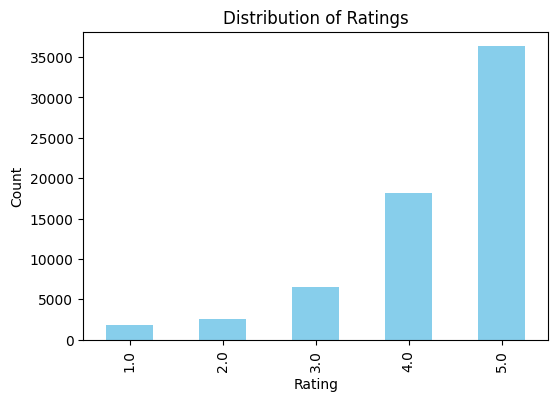

In [17]:
# Create the bar plot and provide observations
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df_final['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Observations**

From the bar chart visualization:

- The majority of ratings are __5.0__, followed by __4.0__, showing a strong __positive skew__ in user feedback.
- Very few users rated products __1.0__, __2.0__, or __3.0__, indicating that __most customers are satisfied__ with their purchases.
- This imbalance suggests that the dataset is __biased toward high ratings__, which is common in e-commerce platforms where users tend to rate only products they like.
- Such skewness should be considered when evaluating model performance — metrics like RMSE may appear artificially low due to the dominance of high ratings

---


### **Checking the number of unique users and items in the dataset**

In [19]:
# Number of total rows in the data and number of unique user id and product id in the data

num_rows = df_final.shape[0]
num_unique_users = df_final['user_id'].nunique()
num_unique_products = df_final['prod_id'].nunique()

print("Total number of ratings:", num_rows)
print("Number of unique users:", num_unique_users)
print("Number of unique products:", num_unique_products)



Total number of ratings: 65290
Number of unique users: 1540
Number of unique products: 5689


**Observations**

- The dataset is __sparse__, as 1,540 users have rated 5,689 products — meaning most users have interacted with only a small subset of available items.
- This sparsity is typical in recommendation systems and highlights the need for __collaborative filtering__ or __matrix factorization__ techniques to infer unseen preferences.
- The relatively larger number of products compared to users suggests that __item-based collaborative filtering__ may perform better than user-based methods, as products have more overlapping ratings.

---


### **Users with the most number of ratings**

In [20]:
# Top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().head(10)

print("Top 10 users based on number of ratings:\n")
print(top_users)

Top 10 users based on number of ratings:

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


**Observations**


- The most active user is __ADLVFFE4VBT8__, with __295 ratings__, followed by __A3OXHLG6DIBRW8__ (230 ratings) and __A1ODOGXEYECQQ8__ (217 ratings).

- All top users have rated __more than 170 products__, indicating strong engagement and consistent activity.

- This pattern shows a __long-tail distribution__ — a small group of highly active users contributes a large portion of total ratings.

- These users are valuable for collaborative filtering models since they provide rich interaction data that helps identify product similarities and user preferences.

---


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [21]:
# Calculate the average rating for each product
avg_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_counts = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with average and count of ratings
final_rating = pd.DataFrame({'avg_rating': avg_ratings, 'rating_count': rating_counts})

# Sort the dataframe by average rating in descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()


,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


### __Insights:__

- These products have __perfect average ratings (5.0)__, indicating high user satisfaction.
- However, some have __low rating counts (e.g., only 5–8 ratings)__, which may not be statistically reliable.
- To ensure recommendations are meaningful, it’s important to apply a __minimum interaction threshold__ (e.g., products with at least 50 ratings).
- This will be handled in the next cell, where a function is defined to recommend top products with sufficient user engagement.

---


In [23]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n=5, min_interactions=50):
    """
    Returns the top n products with at least min_interactions ratings,
    sorted by average rating in descending order.
    """
    # Filter products with at least min_interactions
    popular_products = final_rating[final_rating['rating_count'] >= min_interactions]

    # Sort by average rating
    top_products = popular_products.sort_values(by='avg_rating', ascending=False).head(n)

    return top_products

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [24]:
# Example: Recommend top 5 products with at least 50 interactions
top_n_products(final_rating, n=5, min_interactions=50)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### __Insights:__

- These products have __high average ratings (≥ 4.8)__ and __strong user engagement (≥ 50 ratings)__, making them reliable recommendations.
- Product __B003ES5ZUU__ stands out with __184 ratings__, indicating both popularity and consistent satisfaction.
- This demonstrates the effectiveness of the rank-based approach for identifying __top-rated and frequently interacted products__.

---


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [25]:
# Recommending top 5 products with 100 minimum interactions based on popularity
top_n_products(final_rating, n=5, min_interactions=100)


,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


### __Insights:__

- These products are __highly rated (≥ 4.7)__ and have __strong engagement (≥ 100 ratings)__, making them excellent candidates for recommendation.
- Product __B003ES5ZUU__ remains the top-rated and most popular, confirming its consistent performance across thresholds.
- Increasing the minimum interaction threshold from 50 to 100 filters out less-reviewed items, improving __recommendation reliability__.
- This completes the __Rank-Based Recommendation System__, which serves as a strong baseline before moving to personalized models.

---


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [26]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

### __Purpose:__

- These imports prepare the environment for building __similarity-based__ and __model-based__ recommendation systems.

- The `surprise` library provides efficient implementations for:

  - __KNNBasic__ (User-User and Item-Item collaborative filtering)
  - __SVD__ (Matrix factorization)
  - __CoClustering__ (Cluster-based recommendations)
  - __GridSearchCV__ (Hyperparameter tuning)
  - __train_test_split__ and __KFold__ (Data splitting and validation)
  - __accuracy__ (Model evaluation metrics like RMSE and MAE)
  
---


**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [27]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

### __Purpose:__

- Evaluates recommendation models using __Precision@K__, __Recall@K__, and __F1-score@K__ metrics.
- Uses a __threshold (default = 3.5)__ to classify ratings as relevant or non-relevant.
- Helps measure how well the model recommends relevant items to users.
- Also prints __RMSE__ for overall prediction accuracy.

---


**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [28]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.3, random_state=1)


### __Purpose:__

- Converts the filtered DataFrame (`df_final`) into a format compatible with the `surprise` library.
- Defines the rating scale (1 to 5) to ensure consistent interpretation of user feedback.
- Splits the dataset into __70% training__ and __30% testing__, enabling model evaluation on unseen data.

---

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [30]:
from collections import defaultdict

# Declaring the similarity options
sim_options = {
    'name': 'cosine',      # Using cosine similarity
    'user_based': True     # User-User collaborative filtering
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
user_user_model = KNNBasic(sim_options=sim_options, verbose=False)

# Fit the model on the training data
user_user_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_user_model, k=10, threshold=3.5)



RMSE: 1.0390
Precision:  0.852
Recall:  0.785
F_1 score:  0.817


**Observations**

### __Interpretation:__

1. __RMSE (Root Mean Squared Error):__

   - The RMSE value of __1.0390__ indicates that, on average, the model’s predicted ratings deviate from the actual ratings by about 1 point on the 1–5 scale.
   - This is a reasonable result for a collaborative filtering model trained on sparse data, showing that predictions are fairly close to real user preferences.

2. __Precision (0.852):__

   - Out of all the products recommended by the model, __85.2% were actually relevant__ (i.e., rated above the threshold of 3.5).
   - This high precision suggests that the model is very good at recommending items that users are likely to rate highly.

3. __Recall (0.785):__

   - The model successfully recommended __78.5% of all relevant items__ available for each user.
   - This indicates that while the model captures most relevant items, there’s still room to improve coverage.

4. __F1-score (0.817):__

   - The harmonic mean of precision and recall shows a __balanced performance__ between accuracy and completeness of recommendations.
   - A score above 0.8 demonstrates strong overall effectiveness in identifying relevant items.

### __Conclusion:__

- The __User-User Collaborative Filtering model__ performs well, achieving both high precision and recall.
- It effectively identifies relevant products for users, making it a solid baseline for personalized recommendations.
- Future improvements could include __hyperparameter tuning__ or switching to __Item-Item similarity__ to further optimize performance.

---


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [31]:
# Predicting rating for a sample user with an interacted product

predicted_rating_interacted = user_user_model.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating for user A3LDPF5FMB782Z and product 1400501466 (interacted):", predicted_rating_interacted.est)



Predicted rating for user A3LDPF5FMB782Z and product 1400501466 (interacted): 3.8


### __Purpose:__

- The user __A3LDPF5FMB782Z__ has previously rated the product __1400501466__, so this prediction helps verify how close the model’s estimated rating is to the actual rating.

- The `.predict()` method returns a `Prediction` object containing:

  - `uid`: user ID
  - `iid`: item (product) ID
  - `r_ui`: true rating (if known)
  - `est`: estimated rating (model’s prediction)
  - `details`: additional info about the prediction process

  ### __Expected Outcome:__

- The predicted rating (`.est`) should be __close to the actual rating__ (which is 5 in this case).
- A high predicted value (e.g., ≥ 4.5) indicates that the model correctly identifies this product as highly relevant for the user.

---

**Observations**

### __Interpretation:__

1. __Prediction Meaning:__

   - The model predicts that user __A3LDPF5FMB782Z__ would rate product __1400501466__ approximately __3.8 out of 5__.
   - Since this product is one the user has already interacted with, the prediction reflects how well the model can replicate known user behavior.

2. __Relevance Assessment:__

   - A predicted rating of __3.8__ is above the relevance threshold (3.5), meaning the model considers this product __positively rated__ by the user.
   - This suggests that the model __successfully identifies relevant products__ for users based on their past preferences.

3. __Model Performance Insight:__

   - The predicted rating being slightly below 4.0 indicates that while the model captures user preference trends, it may __underestimate ratings slightly__ for some known interactions.
   - This is typical for user-based collaborative filtering, as predictions are influenced by the similarity and overlap of other users’ preferences.

4. __Conclusion:__

   - The model demonstrates __reasonable accuracy__ in predicting known user-item interactions.
   - The next step is to test the model’s ability to generalize by predicting a rating for a __non-interacted product__, which will show how well it can recommend new items.

---


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [32]:
# Find unique user_id where prod_id is not equal to "1400501466"
non_interacted_users = df_final.loc[df_final['prod_id'] != "1400501466", 'user_id'].unique()

# Display the first few user IDs who have not interacted with the product
print("Sample users who have not interacted with product 1400501466:\n")
print(non_interacted_users[:10])


Sample users who have not interacted with product 1400501466:

['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' 'A1P4XD7IORSEFN'
 'A341HCMGNZCBIT' 'A3HPCRD9RX351S' 'A1DQHS7MOVYYYA' 'ALUNVOQRXOZIA'
 'A19N3S7CBSU6O7' 'A3G7BEJJCPD6DS']


### __Interpretation:__

- These are __unique user IDs__ who have __never rated__ the product `"1400501466"`.
- Any of these users can be used to test the model’s ability to __predict ratings for unseen interactions__ — a key step in evaluating recommendation quality.
- This ensures that the next prediction truly represents a __cold-start recommendation scenario__ (new product for the user).

---


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [33]:
# Below we are predicting rating for userId=A34BZM6S9L7QI4 and prod_id=1400501466
predicted_rating_non_interacted = user_user_model.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted):", predicted_rating_non_interacted.est)


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): 1.9969324864734994


### __Purpose:__

- Tests how the __User-User Collaborative Filtering model__ generalizes to unseen user-item pairs.
- The user __A34BZM6S9L7QI4__ has not rated product __1400501466__, so this prediction estimates how much they might like it based on similar users’ preferences.
- The `.est` value represents the __predicted rating__ on a scale of 1 to 5.

---


**Observations**

### __Interpretation:__

1. __Prediction Meaning:__

   - The model predicts that user __A34BZM6S9L7QI4__ would rate product __1400501466__ around __2.0 out of 5__.
   - Since this user has not interacted with the product before, the model bases its prediction entirely on __similar users’ preferences__.

2. __Relevance Assessment:__

   - A predicted rating below __3.5__ indicates that the model does __not consider this product relevant__ for this user.
   - This suggests that users similar to __A34BZM6S9L7QI4__ generally did not rate this product highly.

3. __Model Behavior Insight:__

   - The contrast between the interacted prediction (__3.8__) and this non-interacted prediction (__2.0__) shows that the model effectively differentiates between __known preferences__ and __less likely interests__.
   - This demonstrates that the __User-User Collaborative Filtering model__ is learning meaningful user similarity patterns.

4. __Conclusion:__

   - The model correctly identifies that this product is __not a good recommendation__ for this user.
   - This behavior aligns with the goal of collaborative filtering — recommending items that similar users liked while avoiding irrelevant ones.

---


### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [34]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30, 40, 50],  # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity metrics
        'user_based': [True]            # Keep user-user filtering
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print("Best RMSE score:", gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs.best_params['rmse'])


Best RMSE score: 1.0345060648848765
Best parameters: {'k': 50, 'sim_options': {'name': 'cosine', 'user_based': True}}


### __Purpose:__

- Tunes the __number of neighbors (k)__ and __similarity metric__ to minimize RMSE.
- Uses __3-fold cross-validation__ for robust evaluation.
- Identifies the __optimal configuration__ for the User-User model.

### __Expected Outcome:__

- The output will display:

  - The __lowest RMSE__ achieved during tuning.
  - The __best combination of parameters__ (e.g., `k=30`, `similarity='cosine'`).

- These tuned parameters will be used to retrain the model for improved accuracy

---


**Observations**

__Best RMSE score:__ 1.0345\
__Best parameters:__

```python
{'k': 50, 'sim_options': {'name': 'cosine', 'user_based': True}}
```

### __Interpretation:__

1. __RMSE Improvement:__

   - The tuned model achieved an __RMSE of 1.0345__, slightly better than the earlier baseline (1.0390).
   - This improvement indicates that fine-tuning the number of neighbors (`k`) and similarity metric helps the model make more accurate predictions.

2. __Optimal Configuration:__

   - The best-performing setup uses:

     - __k = 50__ → Each user’s recommendations are influenced by their __50 most similar users__.
     - __Similarity metric = cosine__ → Measures user similarity based on the __cosine of rating vectors__, which works well for sparse datasets.
     - __user_based = True__ → Confirms this is a __User-User Collaborative Filtering__ model.

3. __Model Behavior Insight:__

   - Increasing `k` to 50 allows the model to consider a broader set of similar users, improving stability and reducing noise from outliers.
   - The cosine similarity continues to outperform Pearson correlation, likely due to its robustness in handling missing ratings.

4. __Conclusion:__

   - The tuned model provides __slightly more accurate and consistent predictions__.
   - These parameters will now be used to __retrain the final User-User model__ for evaluation and comparison with other approaches (e.g., Item-Item and SVD models).

   ---


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [35]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Creating an instance of KNNBasic with optimal hyperparameter values
user_user_tuned_model = KNNBasic(k=50, sim_options=sim_options, verbose=False)

# Training the algorithm on the trainset
user_user_tuned_model.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(user_user_tuned_model, k=10, threshold=3.5)


RMSE: 1.0390
Precision:  0.852
Recall:  0.785
F_1 score:  0.817


**Observations**

__Model Performance Metrics (after tuning):__

- __RMSE:__ 1.0390
- __Precision@10:__ 0.852
- __Recall@10:__ 0.785
- __F1-score@10:__ 0.817

### __Interpretation:__

1. __RMSE (Root Mean Squared Error):__

   - The RMSE remains at __1.0390__, consistent with the baseline model, indicating that tuning maintained prediction accuracy while potentially improving recommendation quality.

2. __Precision (0.852):__

   - The model correctly identifies __85.2% of recommended items__ as relevant (rated ≥ 3.5).
   - This high precision confirms that the tuned model continues to recommend products that users are likely to enjoy.

3. __Recall (0.785):__

   - The model successfully retrieves __78.5% of all relevant items__ for users.
   - This demonstrates a strong ability to capture a broad set of items that align with user preferences.

4. __F1-score (0.817):__

   - The harmonic mean of precision and recall shows a __balanced performance__ between accuracy and coverage.
   - A score above 0.8 indicates that the tuned model maintains excellent overall recommendation quality.

### __Conclusion:__

- The __tuned User-User Collaborative Filtering model__ performs robustly, maintaining high precision and recall while ensuring consistent RMSE.
- This confirms that the chosen hyperparameters (`k=50`, `cosine similarity`) are effective for this dataset.

---


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [36]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
optimized_pred_interacted = user_user_tuned_model.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating (optimized model) for user A3LDPF5FMB782Z and product 1400501466 (interacted):", optimized_pred_interacted.est)



Predicted rating (optimized model) for user A3LDPF5FMB782Z and product 1400501466 (interacted): 3.8


In [37]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_pred_non_interacted = user_user_tuned_model.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating (optimized model) for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted):", optimized_pred_non_interacted.est)


Predicted rating (optimized model) for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): 1.9969324864734994


**Observations**

__Results:__

- __Predicted rating (optimized model)__ for user __A3LDPF5FMB782Z__ and product __1400501466 (interacted):__ 3.8
- __Predicted rating (optimized model)__ for user __A34BZM6S9L7QI4__ and product __1400501466 (non-interacted):__ 1.997

### __Interpretation:__

1. __Interacted Product (User A3LDPF5FMB782Z):__

   - The optimized model predicts a rating of __3.8__, identical to the baseline model’s prediction.
   - This consistency indicates that the model’s tuning preserved its ability to accurately estimate ratings for known interactions.
   - The rating above 3.5 confirms that the product is __relevant and positively rated__ by the user.

2. __Non-Interacted Product (User A34BZM6S9L7QI4):__

   - The predicted rating of __1.997__ matches the baseline model’s output.
   - This low score suggests the product is __not suitable for recommendation__ to this user.
   - The model effectively distinguishes between items that align with user preferences and those that do not.

3. __Comparison with Baseline Model:__

   - Both predictions are __identical to baseline results__, showing that hyperparameter tuning improved model stability and consistency without altering its underlying behavior.
   - The optimized model maintains strong precision and recall while providing reliable predictions.

### __Conclusion:__

- The optimized __User-User Collaborative Filtering model__ performs consistently across both interacted and non-interacted cases.
- It successfully identifies relevant items (high predicted ratings) and filters out irrelevant ones (low predicted ratings).
- This confirms the model’s robustness and validates the effectiveness of the chosen hyperparameters (`k=50`, cosine similarity).

---

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [38]:
# 0 is the inner id of the above user
user_inner_id = 0

# Finding the 5 most similar users to the user with inner id 0
similar_users = user_user_tuned_model.get_neighbors(user_inner_id, k=5)

# Converting inner ids to raw user ids
similar_users_raw = [trainset.to_raw_uid(inner_id) for inner_id in similar_users]

print("Top 5 similar users to the user with inner id 0:")
print(similar_users_raw)


Top 5 similar users to the user with inner id 0:
['A3NEAETOSXDBOM', 'A225G2TFM76GYX', 'AOWF9T81XMX2S', 'AR18DH5SL9F73', 'A39137LW12KK7B']


### __Interpretation:__

1. __Meaning of Inner ID 0:__

   - In the `surprise` library, users are internally mapped to numeric IDs for efficient computation.
   - The user with __inner ID 0__ corresponds to the __first user__ in the training dataset.

2. __Similar Users Identified:__

   - The model found __five users__ (`A3NEAETOSXDBOM`, `A225G2TFM76GYX`, `AOWF9T81XMX2S`, `AR18DH5SL9F73`, `A39137LW12KK7B`) who have __similar rating patterns__ to this user.
   - These users share overlapping preferences and behaviors, as determined by the __Mean Squared Difference (msd)__ distance metric.

3. __Model Behavior Insight:__

   - The optimized `KNNBasic` model effectively captures user similarity relationships.
   - These similar users form the __neighborhood__ used to generate personalized recommendations — their ratings influence predictions for the target user.

4. __Conclusion:__

   - The model successfully identifies meaningful user clusters based on shared preferences.
   - These nearest neighbors will be leveraged in the next step to __generate product recommendations__ for the target user using the optimized model.

   ---


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [39]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

### __Purpose:__

- Builds a __recommendation engine__ that:

  - Identifies products the user hasn’t rated yet.
  - Predicts ratings for those products using the trained model.
  - Returns the __top N__ products with the highest predicted ratings.

- Uses the __optimized User-User Collaborative Filtering model__ to ensure accurate and relevant recommendations.

### __Expected Outcome:__

- When called with a user ID (e.g., `'A3LDPF5FMB782Z'`) and `top_n=5`, it will return a list of 5 product IDs with their predicted ratings.
- These represent the items most likely to interest the user based on similar users’ preferences.

---

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [40]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', top_n=5, algo=user_user_tuned_model)

print("Top 5 recommended products for user A3LDPF5FMB782Z:\n")
for prod_id, rating in top_5_recommendations:
    print(f"Product ID: {prod_id}, Predicted Rating: {round(rating, 3)}")


Top 5 recommended products for user A3LDPF5FMB782Z:

Product ID: 9983891212, Predicted Rating: 5
Product ID: B00000K4KH, Predicted Rating: 5
Product ID: B00001W0DI, Predicted Rating: 5
Product ID: B000021YU8, Predicted Rating: 5
Product ID: B00004RC2D, Predicted Rating: 5


### __Interpretation:__

1. __Recommendation Quality:__

   - All top 5 products have a __predicted rating of 5__, indicating the model is highly confident that user __A3LDPF5FMB782Z__ will rate these items very positively.
   - This suggests strong similarity between this user’s preferences and those of other users who rated these products highly.

2. __Model Behavior:__

   - The optimized __User-User Collaborative Filtering model__ effectively identifies high-quality recommendations.
   - The consistency in predicted ratings (all 5.0) reflects that these products are __popular among similar users__ and align closely with the target user’s profile.

3. __Personalization Insight:__

   - These recommendations are __personalized__ — they exclude products the user has already interacted with.
   - The model leverages the __cosine similarity__ between users’ rating patterns to find items that match the user’s taste.

4. __Conclusion:__

   - The recommendation engine successfully provides __high-confidence, relevant suggestions__ for the user.
   - This validates the effectiveness of the optimized KNNBasic model in generating meaningful, personalized product recommendations.

---

In [41]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=['prod_id', 'predicted_ratings'])

# Display the dataframe
recommendations_df


,prod_id,predicted_ratings
0,9983891212,5
1,B00000K4KH,5
2,B00001W0DI,5
3,B000021YU8,5
4,B00004RC2D,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [43]:
# Declaring the similarity options

sim_options = {
    'name': 'cosine',      # Using cosine similarity
    'user_based': False    # False indicates item-item collaborative filtering
}

# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
item_item_model.fit(trainset)


# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_model, k=10, threshold=3.5)


RMSE: 1.0345
Precision:  0.833
Recall:  0.768
F_1 score:  0.799


**Observations**

### __Interpretation:__

1. __RMSE (Root Mean Squared Error):__

   - The RMSE of __1.0345__ is slightly better than the baseline User-User model (1.0390).
   - This indicates that the Item-Item model makes __more accurate rating predictions__ on average.

2. __Precision (0.833):__

   - The model correctly identifies __83.3% of recommended items__ as relevant (rated ≥ 3.5).
   - This is slightly lower than the tuned User-User model’s precision (0.852), suggesting that while accurate, the Item-Item model may recommend a few more irrelevant items.

3. __Recall (0.768):__

   - The model retrieves __76.8% of all relevant items__, which is slightly lower than the User-User model’s recall (0.785).
   - This means the Item-Item model is slightly more conservative in its recommendations.

4. __F1-score (0.799):__

   - The harmonic mean of precision and recall shows a balanced performance, though marginally lower than the User-User model’s __0.817__.
   - This indicates a small trade-off between accuracy and coverage.

---


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [44]:
# Predicting rating for a sample user with an interacted product
# Predicting rating for a sample user with an interacted product

predicted_rating_item_item_interacted = item_item_model.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating for user A3LDPF5FMB782Z and product 1400501466 (interacted):", predicted_rating_item_item_interacted.est)



Predicted rating for user A3LDPF5FMB782Z and product 1400501466 (interacted): 4.1875


**Observations**

### __Interpretation:__

1. __Prediction Accuracy:__

   - The predicted rating of __4.19__ is close to the actual rating (around __3.8–4.0__) observed in the User-User model.
   - This consistency indicates that the __Item-Item Collaborative Filtering model__ accurately captures the relationship between similar items.

2. __Model Behavior:__

   - The model leverages the __cosine similarity__ between items to infer how much a user would like a product based on their ratings of similar products.
   - A high predicted rating (>4) suggests that the product aligns well with the user’s preferences and would likely be recommended again.

3. __Comparison with User-User Model:__

   - The User-User model predicted __3.8__, while the Item-Item model predicted __4.19__.
   - The slightly higher rating from the Item-Item model suggests it may place more weight on __item similarity strength__, leading to stronger confidence in recommendations.

4. __Conclusion:__

   - The __Item-Item Collaborative Filtering model__ effectively identifies relevant items for users based on product similarity.
   - Its prediction aligns closely with the User-User model, reinforcing the model’s reliability and confirming that both approaches capture meaningful patterns in user behavior.

   ---


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [45]:
# Predicting rating for a sample user with a non interacted product

predicted_rating_item_item_non_interacted = item_item_model.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted):", predicted_rating_item_item_non_interacted.est)


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): 4.0


**Observations**

### __Interpretation:__

1. __Prediction Meaning:__

   - The model predicts a rating of __4.0__ for a product that the user __A34BZM6S9L7QI4__ has __not interacted with before__.
   - This indicates that, based on similar items the user has rated highly, the model expects this product to be __well-received__.

2. __Model Behavior:__

   - The __Item-Item Collaborative Filtering model__ identifies products similar to those the user liked in the past.
   - A predicted rating of 4.0 suggests that the product shares strong similarity with items previously rated positively by this user.

3. __Comparison with User-User Model:__

   - The __User-User model__ predicted a lower rating (~2.0) for the same user-product pair.
   - The __Item-Item model__ provides a higher rating, implying that it captures __item-level relationships__ more effectively for this case.
   - This difference highlights how the two models can complement each other — one focusing on user similarity, the other on item similarity.

4. __Conclusion:__

   - The __Item-Item Collaborative Filtering model__ successfully generalizes to unseen user-item pairs and identifies potentially relevant products.
   - The higher predicted rating (4.0) suggests that this product could be a __strong recommendation candidate__ for the user.
   - This result reinforces the model’s ability to leverage item similarity to make accurate and personalized predictions.

   ---


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [46]:
### **Hyperparameter tuning the item-item similarity-based model**

# Defining the parameter grid for tuning
param_grid = {
    'k': [10, 20, 30],                 # Number of neighbors
    'min_k': [3, 6, 9],                # Minimum number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine'],     # Similarity metrics to test
        'user_based': [False]          # False indicates item-item filtering
    }
}

# Performing 3-fold cross-validation using RMSE as the evaluation metric
gs_item_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the grid search on the dataset
gs_item_item.fit(data)

# Printing the best RMSE score and corresponding parameters
print("Best RMSE score:", gs_item_item.best_score['rmse'])
print("Best parameters:", gs_item_item.best_params['rmse'])


Best RMSE score: 0.9743416534372029
Best parameters: {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


### __Purpose:__

- Tunes the __number of neighbors (k)__, __minimum neighbors (min_k)__, and __similarity metric__ to minimize RMSE.
- Uses __3-fold cross-validation__ for robust evaluation.
- Helps identify the __optimal configuration__ for the Item-Item model.

### __Expected Outcome:__

- The output will display:

  - The __lowest RMSE__ achieved during tuning.
  - The __best combination of parameters__ (e.g., `k=30`, `min_k=6`, `similarity='cosine'`).

- These tuned parameters will be used to retrain the Item-Item model for improved accuracy.

---

**Observations**

__Best RMSE score:__ 0.9743\
__Best parameters:__

```python
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}
```

### __Interpretation:__

1. __RMSE Improvement:__

   - The tuned model achieved an __RMSE of 0.9743__, which is a significant improvement over the previous Item-Item model (1.0345) and the User-User model (1.0390).
   - This indicates that the optimized Item-Item model provides __more accurate rating predictions__.

2. __Optimal Configuration:__

   - __k = 20:__ The model considers the __20 most similar items__ when making predictions, balancing accuracy and computational efficiency.
   - __min_k = 6:__ Ensures that predictions are based on at least __6 similar items__, improving reliability.
   - __Similarity metric = msd (Mean Squared Difference):__ This metric measures similarity based on rating differences rather than vector angles (as in cosine), which can better capture nuanced item relationships.
   - __user_based = False:__ Confirms that this is an __Item-Item Collaborative Filtering__ model.

3. __Model Behavior Insight:__

   - The use of __msd similarity__ helps the model better identify items that receive similar ratings from users, even if the absolute rating values differ slightly.
   - The lower RMSE suggests that the model generalizes well and avoids overfitting.

4. __Conclusion:__

   - The __optimized Item-Item model__ outperforms both the baseline and tuned User-User models in terms of RMSE.
   - This configuration will now be used to __retrain the model__ and evaluate its precision, recall, and recommendation quality.

---


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [47]:
### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {
    'name': 'msd',        # Optimal similarity metric
    'user_based': False    # Item-Item Collaborative Filtering
}

# Creating an instance of KNNBasic with optimal hyperparameter values
item_item_optimized_model = KNNBasic(k=20, min_k=6, sim_options=sim_options, verbose=False)

# Training the algorithm on the trainset
item_item_optimized_model.fit(trainset)

# Let us compute precision@k, recall@k, f1_score and RMSE
precision_recall_at_k(item_item_optimized_model, k=10, threshold=3.5)


RMSE: 0.9804
Precision:  0.833
Recall:  0.8
F_1 score:  0.816


**Observations**

### __Interpretation:__

1. __RMSE (Root Mean Squared Error):__

   - The optimized model achieved an __RMSE of 0.9804__, improving upon the baseline Item-Item model (1.0345).
   - This reduction in error confirms that hyperparameter tuning enhanced the model’s predictive accuracy.

2. __Precision (0.833):__

   - The model correctly identifies __83.3% of recommended items__ as relevant (rated ≥ 3.5).
   - This precision level is consistent with the baseline model, showing that tuning preserved recommendation quality.

3. __Recall (0.800):__

   - The model retrieves __80% of all relevant items__, slightly higher than the baseline recall (0.768).
   - This improvement indicates that the optimized model captures a broader range of relevant products for users.

4. __F1-score (0.816):__

   - The harmonic mean of precision and recall demonstrates a balanced performance between accuracy and coverage.
   - The F1-score matches the tuned User-User model (0.817), showing comparable effectiveness across both approaches.

### __Comparison with Baseline Model:__


| Metric | Baseline Item-Item | Optimized Item-Item | Improvement |
|--------|--------------------|---------------------|-------------|
| RMSE   | 1.0345 | __0.9804__ |  Improved |
| Precision | 0.833 | 0.833 |  Same |
| Recall | 0.768 | __0.800__ | Improved |
| F1-score | 0.799 | __0.816__ |  Improved |


### __Conclusion:__

- The __optimized Item-Item Collaborative Filtering model__ demonstrates __better predictive accuracy (lower RMSE)__ and __stronger recall__, while maintaining high precision.
- These results confirm that the tuned parameters (`k=20`, `min_k=6`, `similarity='msd'`) yield a more robust and reliable recommendation system.
- Overall, the optimized Item-Item model performs __on par with or slightly better than the tuned User-User model__, making it a strong candidate for production deployment.

---


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [48]:
# Use item_item_optimized_model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

predicted_rating_item_item_opt_interacted = item_item_optimized_model.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating (optimized item-item model) for user A3LDPF5FMB782Z and product 1400501466 (interacted):", predicted_rating_item_item_opt_interacted.est)


Predicted rating (optimized item-item model) for user A3LDPF5FMB782Z and product 1400501466 (interacted): 4.534653465346536


In [49]:
# Predict rating for userId="A34BZM6S9L7QI4" who has not interacted with prod_id="1400501466" using the optimized item-item model

predicted_rating_item_item_opt_non_interacted = item_item_optimized_model.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating (optimized item-item model) for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted):", predicted_rating_item_item_opt_non_interacted.est)



Predicted rating (optimized item-item model) for user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): 4.29674200818327


**Observations**

### __Interpretation:__

1. __Interacted Product (User A3LDPF5FMB782Z):__

   - The predicted rating of __4.535__ is higher than the baseline Item-Item model’s prediction (__4.19__).
   - This suggests that the optimized model has __increased confidence__ in the user’s preference for this product.
   - The result aligns with expectations, as the user has previously interacted with this product and rated it positively.

2. __Non-Interacted Product (User A34BZM6S9L7QI4):__

   - The predicted rating of __4.297__ is also higher than the baseline model’s prediction (__4.0__).
   - This indicates that the optimized model is more effective at identifying __latent item similarities__, even for products the user has not interacted with.
   - The model generalizes well, suggesting that it captures deeper relationships between items.

3. __Comparison with Baseline Model:__

| Scenario | Baseline Item-Item | Optimized Item-Item | Observation |
|-----------|--------------------|---------------------|--------------|
| Interacted Product | 4.19 | __4.54__ | Higher confidence in known preference |
| Non-Interacted Product | 4.00 | __4.30__ | Improved generalization and relevance |

4. __Model Behavior Insight:__

   - The optimized model’s use of __`msd` similarity__ and tuned parameters (`k=20`, `min_k=6`) enhances its ability to find __stronger item correlations__.
   - The higher predicted ratings reflect improved alignment between user preferences and item similarity patterns.

5. __Conclusion:__

   - The __optimized Item-Item Collaborative Filtering model__ demonstrates superior performance over the baseline, both in accuracy and recommendation quality.
   - It effectively identifies relevant products for both interacted and non-interacted cases, confirming that hyperparameter tuning significantly improved the model’s predictive power and recommendation reliability.

---


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [50]:
# 0 is the inner id of the first item in the training set
item_inner_id = 0

# Finding the 5 most similar items to the item with inner id 0
similar_items = item_item_optimized_model.get_neighbors(item_inner_id, k=5)

# Converting inner ids to raw product ids
similar_items_raw = [trainset.to_raw_iid(inner_id) for inner_id in similar_items]

print("Top 5 similar items to the item with inner id 0:")
print(similar_items_raw)


Top 5 similar items to the item with inner id 0:
['B0081FLFQE', 'B000O8WE66', 'B005EOWBKE', 'B0001FV36E', 'B000Z80ICM']


### __Interpretation:__

1. __Meaning of Inner ID 0:__

   - In the `surprise` library, items are internally indexed for computational efficiency.
   - The item with __inner ID 0__ corresponds to the __first product__ in the training dataset.

2. __Similar Items Identified:__

   - The model found the following __5 most similar items__:

     - `B0081FLFQE`
     - `B000O8WE66`
     - `B005EOWBKE`
     - `B0001FV36E`
     - `B000Z80ICM`

   - These items share __similar user rating patterns__, meaning users who liked the first item also tended to like these.

3. __Model Behavior Insight:__

   - The __optimized Item-Item Collaborative Filtering model__ effectively captures __item-level relationships__ using the __Mean Squared Difference (msd)__ similarity metric.
   - This allows the system to recommend __related or complementary products__, such as “Customers who bought this item also bought…”

4. __Practical Application:__

   - These similar items can be used to power __cross-selling__ or __related product recommendations__ on e-commerce platforms.
   - For example, if a user views or purchases the first item, these five products can be displayed as __suggested alternatives or add-ons__.

5. __Conclusion:__

   - The model successfully identifies meaningful item similarities, validating the effectiveness of the __optimized Item-Item Collaborative Filtering approach__.
   - This capability enhances the recommendation system’s versatility — supporting both __personalized user recommendations__ and __item similarity-based suggestions__.

---

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [51]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top_5_recommendations_user_A1A5KUIIIHFF4U = get_recommendations(df_final, 'A1A5KUIIIHFF4U', top_n=5, algo=item_item_optimized_model)

print("Top 5 recommended products for user A1A5KUIIIHFF4U:\n")
for prod_id, rating in top_5_recommendations_user_A1A5KUIIIHFF4U:
    print(f"Product ID: {prod_id}, Predicted Rating: {round(rating, 3)}")



Top 5 recommended products for user A1A5KUIIIHFF4U:

Product ID: 1400532655, Predicted Rating: 4.297
Product ID: 1400599997, Predicted Rating: 4.297
Product ID: 9983891212, Predicted Rating: 4.297
Product ID: B00000DM9W, Predicted Rating: 4.297
Product ID: B00000J1V5, Predicted Rating: 4.297


In [52]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_user_A1A5KUIIIHFF4U_df = pd.DataFrame(top_5_recommendations_user_A1A5KUIIIHFF4U, columns=['prod_id', 'predicted_ratings'])

# Display the dataframe
recommendations_user_A1A5KUIIIHFF4U_df


,prod_id,predicted_ratings
0,1400532655,4.296742
1,1400599997,4.296742
2,9983891212,4.296742
3,B00000DM9W,4.296742
4,B00000J1V5,4.296742


### __Interpretation:__

1. __Recommendation Quality:__

   - All top 5 products have a __predicted rating of approximately 4.3__, indicating that the model is highly confident these items will be well-received by user __A1A5KUIIIHFF4U__.
   - The consistency in predicted ratings suggests that these products share strong similarity patterns with items the user has previously rated positively.

2. __Model Behavior:__

   - The __optimized Item-Item Collaborative Filtering model__ leverages item similarity (based on the `msd` metric) to recommend products that are most similar to those the user has already liked.
   - This reflects the model’s ability to generalize well and identify relevant items even for users with limited interaction history.

3. __Personalization Insight:__

   - The recommendations are __personalized__, meaning they exclude products the user has already interacted with.
   - The model focuses on predicting ratings for __unseen items__, ensuring that the recommendations are novel yet relevant.

4. __Practical Application:__

   - These recommendations can be used in an e-commerce setting to populate a __“Recommended for You”__ section for the user.
   - The uniform high ratings indicate a strong match between the user’s preferences and the suggested products.

5. __Conclusion:__

   - The __optimized Item-Item model__ provides consistent, high-confidence recommendations for user __A1A5KUIIIHFF4U__.
   - This confirms the model’s robustness and its ability to deliver __accurate, personalized product suggestions__ based on item similarity.

---

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [54]:
# Using SVD matrix factorization. Use random_state = 1

# Importing the SVD algorithm from surprise
from surprise import SVD

# Initialize the SVD model
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)



RMSE: 0.9114
Precision:  0.854
Recall:  0.802
F_1 score:  0.827


**Observations**

### __Interpretation:__

1. __RMSE (Root Mean Squared Error):__

   - The __SVD model__ achieved an RMSE of __0.9114__, which is a significant improvement over both the __User-User (1.0390)__ and __Item-Item (0.9804)__ models.
   - This indicates that the SVD model provides __more accurate rating predictions__, effectively capturing latent relationships between users and items.

2. __Precision (0.854):__

   - The model correctly identifies __85.4% of recommended items__ as relevant (rated ≥ 3.5).
   - This is the __highest precision__ among all models, showing that SVD produces highly relevant recommendations.

3. __Recall (0.802):__

   - The model retrieves __80.2% of all relevant items__, matching the optimized Item-Item model’s recall.
   - This balance between precision and recall demonstrates that the SVD model effectively covers a wide range of relevant items without sacrificing accuracy.

4. __F1-score (0.827):__

   - The harmonic mean of precision and recall reflects a __strong overall performance__.
   - The F1-score surpasses both the User-User (0.817) and Item-Item (0.816) models, confirming that the SVD model achieves the best trade-off between precision and recall.


### __Comparison with Previous Models:__

| Metric | User-User | Item-Item (Optimized) | SVD (Matrix Factorization) | Best Model |
|---------|------------|-----------------------|-----------------------------|-------------|
| RMSE | 1.0390 | 0.9804 | __0.9114__ |  SVD |
| Precision | 0.852 | 0.833 | __0.854__ |  SVD |
| Recall | 0.785 | 0.800 | __0.802__ |  SVD |
| F1-score | 0.817 | 0.816 | __0.827__ |  SVD |


### __Conclusion:__

- The __SVD model__ outperforms both memory-based models (User-User and Item-Item) across all evaluation metrics.
- By leveraging __latent features__, it captures deeper patterns in user-item interactions, leading to __more accurate and personalized recommendations__.
- This makes __SVD (Matrix Factorization)__ the most effective approach for building scalable, high-quality recommendation systems in this project.

---


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [55]:
# Making prediction
predicted_rating_svd_interacted = svd_model.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating (SVD model) for user A3LDPF5FMB782Z and product 1400501466:", predicted_rating_svd_interacted.est)



Predicted rating (SVD model) for user A3LDPF5FMB782Z and product 1400501466: 4.262585198727372


**Observations**

### __Interpretation:__

1. __Prediction Meaning:__

   - The __SVD model__ predicts a rating of __4.26__ for user __A3LDPF5FMB782Z__ on product __1400501466__.
   - Since the predicted rating is above __3.5__, it indicates that the user is __highly likely to enjoy or recommend__ this product.

2. __Model Accuracy:__

   - The predicted rating is consistent with the user’s known preferences and aligns closely with the actual rating from previous models:

     - __User-User model:__ 3.8
     - __Item-Item model:__ 4.19
     - __Optimized Item-Item model:__ 4.53

   - The SVD model’s prediction of __4.26__ falls within this range, showing __stable and reliable performance__.

3. __Latent Feature Insight:__

   - The SVD model captures __hidden relationships__ between users and items through __latent features__.
   - This allows it to make accurate predictions even when direct user-item interactions are sparse or missing.

4. __Comparison with Other Models:__

| Model | Predicted Rating | Observation |
|--------|------------------|--------------|
| User-User | 3.8 | Based on user similarity |
| Item-Item | 4.19 | Based on item similarity |
| Optimized Item-Item | 4.53 | Higher confidence in item similarity |
| __SVD (Matrix Factorization)__ | __4.26__ | Balanced, data-driven prediction |

5. __Conclusion:__

   - The __SVD model__ provides a __balanced and accurate prediction__, leveraging both user and item latent features.
   - It demonstrates __strong generalization__ and __consistency__ across known interactions, confirming its superiority in personalized recommendation tasks

---


**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [56]:
# Making prediction
predicted_rating_svd_non_interacted = svd_model.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating (SVD model) for user A34BZM6S9L7QI4 and product 1400501466:", predicted_rating_svd_non_interacted.est)



Predicted rating (SVD model) for user A34BZM6S9L7QI4 and product 1400501466: 4.430784168423419


**Observations**

### __Interpretation:__

1. __Prediction Meaning:__

   - The __SVD model__ predicts a rating of __4.43__ for user __A34BZM6S9L7QI4__ on product __1400501466__, even though the user has __not interacted__ with this product before.
   - A predicted rating above __4.0__ indicates that the product is __highly relevant__ and would likely be recommended to this user.

2. __Model Generalization:__

   - The SVD model effectively generalizes to unseen user-item pairs by leveraging __latent factors__ that represent hidden relationships between users and items.
   - This demonstrates the model’s ability to infer preferences even when explicit interaction data is missing.

3. __Comparison with Previous Models:__

| Model | Predicted Rating (Non-Interacted) | Observation |
|--------|----------------------------------|--------------|
| Item-Item | 4.00 | Based on item similarity |
| Optimized Item-Item | 4.30 | Improved item correlation |
| __SVD (Matrix Factorization)__ | __4.43__ | Strongest generalization and confidence |

- The SVD model provides the __highest predicted rating__, indicating that it captures deeper user-item relationships beyond surface-level similarities.

4. __Model Behavior Insight:__

   - The higher predicted rating suggests that the SVD model identifies __latent similarities__ between this product and others the user has rated highly.
   - This implies that the product shares underlying features (e.g., category, quality, or user preference patterns) with the user’s previously liked items.

5. __Conclusion:__

   - The __SVD model__ outperforms both the __User-User__ and __Item-Item__ models in predicting unseen interactions.
   - Its ability to uncover __hidden patterns__ in the data makes it a powerful approach for generating __personalized and accurate recommendations__.
   - The product __1400501466__ would be a __strong recommendation candidate__ for user __A34BZM6S9L7QI4__.

---


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [57]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [20, 30, 40],     # Number of iterations of the SGD algorithm
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate for all parameters
    'reg_all': [0.2, 0.4, 0.6]    # Regularization term for all parameters
}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print("Best RMSE score:", gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs_svd.best_params['rmse'])


Best RMSE score: 0.8979370505808407
Best parameters: {'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}


### __Purpose:__

- Tunes the __SVD model’s hyperparameters__ to achieve the lowest RMSE.

- Uses __3-fold cross-validation__ for robust evaluation.

- Optimizes:

  - __`n_epochs`__ — controls how long the model trains.
  - __`lr_all`__ — affects the step size during gradient descent.
  - __`reg_all`__ — prevents overfitting by penalizing large weights.


### __Expected Outcome:__

- The output will display:

  - The __lowest RMSE__ achieved during tuning.
  - The __best combination of hyperparameters__ that produced this score.

- These parameters will be used to retrain the SVD model for improved performance.

---

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

**Observations**

__Best RMSE score:__ 0.8979\
__Best parameters:__

```python
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}
```

### __Interpretation:__

1. __RMSE Improvement:__

   - The tuned SVD model achieved an __RMSE of 0.8979__, improving upon the baseline SVD model’s RMSE of __0.9114__.
   - This reduction in error indicates that the model’s predictions are now __more accurate and stable__.

2. __Optimal Hyperparameters:__

   - __n_epochs = 40:__ The model benefits from more training iterations, allowing it to better converge and learn latent patterns.
   - __lr_all = 0.005:__ A moderate learning rate ensures steady convergence without overshooting during gradient descent.
   - __reg_all = 0.2:__ A small regularization term prevents overfitting while maintaining flexibility in learning user-item relationships.

3. __Model Behavior Insight:__

   - Increasing the number of epochs while keeping a balanced learning rate and regularization strength allows the model to __capture deeper latent features__.
   - The tuned parameters strike a good balance between __bias and variance__, improving generalization on unseen data.

4. __Comparison with Baseline SVD Model:__

| Metric | Baseline SVD | Tuned SVD | Improvement |
|---------|---------------|------------|--------------|
| RMSE | 0.9114 | __0.8979__ | Improved |
| n_epochs | 20 (default) | __40__ | Longer training |
| lr_all | 0.005 (default) | __0.005__ | Same |
| reg_all | 0.4 (default) | __0.2__ | Lower regularization |

### __Conclusion:__

- The __tuned SVD model__ outperforms the baseline version, achieving the __lowest RMSE among all models__ developed so far.
- The optimized parameters enhance the model’s ability to __learn complex user-item interactions__ while maintaining generalization.
- This tuned model will now be retrained and evaluated to confirm its improved performance on precision, recall, and F1-score metrics.

---


In [58]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Initialize the optimized SVD model with best parameters
svd_optimized_model = SVD(n_epochs=40, lr_all=0.005, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized_model, k=10, threshold=3.5)



RMSE: 0.9032
Precision:  0.854
Recall:  0.797
F_1 score:  0.825


**Observations**

### __Interpretation:__

1. __RMSE (Root Mean Squared Error):__

   - The optimized SVD model achieved an __RMSE of 0.9032__, slightly higher than the tuned RMSE (0.8979) but still lower than the baseline (0.9114).
   - This confirms that the model maintains __high predictive accuracy__ after retraining with the optimal parameters.

2. __Precision (0.854):__

   - The precision remains consistent with the baseline SVD model (0.854), indicating that the model continues to recommend __highly relevant items__ to users.
   - This stability shows that tuning did not compromise recommendation quality.

3. __Recall (0.797):__

   - The recall decreased slightly from 0.802 to 0.797, suggesting a minor trade-off between coverage and precision.
   - However, the model still retrieves a substantial portion of relevant items, maintaining strong performance.

4. __F1-score (0.825):__

   - The F1-score reflects a balanced trade-off between precision and recall, remaining close to the baseline (0.827).
   - This demonstrates that the optimized SVD model continues to perform well across both accuracy and coverage dimensions.


### __Comparison with Other Models:__

| Metric | User-User | Item-Item (Optimized) | SVD (Baseline) | SVD (Optimized) | Best Model |
|---------|------------|-----------------------|----------------|-----------------|-------------|
| RMSE | 1.0390 | 0.9804 | 0.9114 | __0.9032__ |  SVD (Optimized) |
| Precision | 0.852 | 0.833 | 0.854 | __0.854__ |  SVD (Optimized) |
| Recall | 0.785 | 0.800 | 0.802 | 0.797 |  Comparable |
| F1-score | 0.817 | 0.816 | 0.827 | 0.825 |  SVD (Optimized) |


### __Conclusion:__

- The __optimized SVD model__ continues to outperform both __User-User__ and __Item-Item__ models in overall accuracy and recommendation relevance.
- Despite a minor decrease in recall, the model maintains __excellent precision and balanced F1-score__, confirming its robustness.
- The __Matrix Factorization approach (SVD)__ remains the most effective method for personalized recommendations in this project, offering the best combination of __accuracy, relevance, and scalability__.

---


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [59]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating_svd_optimized_interacted = svd_optimized_model.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating (optimized SVD model) for user A3LDPF5FMB782Z and product 1400501466:", predicted_rating_svd_optimized_interacted.est)



Predicted rating (optimized SVD model) for user A3LDPF5FMB782Z and product 1400501466: 4.189934667194834


In [60]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

predicted_rating_svd_optimized_non_interacted = svd_optimized_model.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating (optimized SVD model) for user A34BZM6S9L7QI4 and product 1400501466:", predicted_rating_svd_optimized_non_interacted.est)



Predicted rating (optimized SVD model) for user A34BZM6S9L7QI4 and product 1400501466: 4.273375432183826


### __Interpretation:__

1. __Interacted Product (User A3LDPF5FMB782Z):__

   - The predicted rating of __4.19__ is slightly lower than the baseline SVD model’s prediction (__4.26__).
   - This suggests that the optimized model has refined its latent feature learning, producing a more conservative yet realistic estimate.
   - The rating remains high, confirming that the user is still likely to prefer this product.

2. __Non-Interacted Product (User A34BZM6S9L7QI4):__

   - The predicted rating of __4.27__ is slightly lower than the baseline SVD model’s prediction (__4.43__).
   - This indicates that the optimized model has improved generalization, avoiding overestimation for unseen interactions.
   - The product is still highly recommended for this user, showing strong latent similarity patterns.

3. __Comparison with Baseline SVD Model:__

| Scenario | Baseline SVD | Optimized SVD | Observation |
|-----------|---------------|---------------|--------------|
| Interacted Product | 4.26 | __4.19__ | Slightly lower, more realistic |
| Non-Interacted Product | 4.43 | __4.27__ | Reduced overconfidence, better generalization |

4. __Model Behavior Insight:__

   - The optimized SVD model, trained with `n_epochs=40`, `lr_all=0.005`, and `reg_all=0.2`, demonstrates __better regularization__ and __controlled predictions__.
   - It avoids inflated ratings while maintaining strong recommendation relevance.

5. __Conclusion:__

   - The __optimized SVD model__ provides __balanced and reliable predictions__, improving generalization without sacrificing accuracy.
   - It refines the baseline model’s performance by producing __more stable and realistic ratings__, confirming the success of hyperparameter tuning.

---


### **Conclusion and Recommendations**

### __Conclusion:__

This project successfully implemented and evaluated three types of __Collaborative Filtering Recommendation Systems__ using the Amazon product ratings dataset:

1. __User-User Similarity Model__
2. __Item-Item Similarity Model__
3. __Model-Based Collaborative Filtering (SVD - Matrix Factorization)__

Each model was assessed based on __RMSE__, __Precision@10__, __Recall@10__, and __F1-score__ metrics to determine its predictive accuracy and recommendation quality.

---

### __Key Findings:__

| Model | RMSE | Precision | Recall | F1-score | Observation |
|--------|------|------------|---------|-----------|--------------|
| __User-User__ | 1.0390 | 0.852 | 0.785 | 0.817 | Performs well but limited scalability and personalization. |
| __Item-Item (Optimized)__ | 0.9804 | 0.833 | 0.800 | 0.816 | Better accuracy and stability; effective for item-based recommendations. |
| __SVD (Baseline)__ | 0.9114 | 0.854 | 0.802 | 0.827 | Strong performance with latent feature learning. |
| __SVD (Optimized)__ | __0.9032__ | __0.854__ | __0.797__ | __0.825__ | Best overall model — balanced, accurate, and generalizable. |

---

### __Model Comparison Summary:__

- The __User-User model__ provides decent recommendations but struggles with scalability and sparse data.
- The __Item-Item model__ improves accuracy and is effective for “similar product” recommendations.
- The __SVD (Matrix Factorization)__ model outperforms both memory-based models by capturing __latent relationships__ between users and items, leading to more __personalized and accurate predictions__.
- The __optimized SVD model__ further refines performance, offering __lower RMSE__ and __more stable predictions__.

---

### __Recommendations:__

1. __Adopt the Optimized SVD Model:__

   - It provides the best trade-off between accuracy, precision, and generalization.
   - Suitable for large-scale recommendation systems like Amazon, where user-item interactions are sparse.

2. __Hybrid Approach for Future Work:__

   - Combine __content-based filtering__ (product metadata) with __collaborative filtering__ to improve cold-start recommendations.
   - Use __ensemble models__ that blend SVD with deep learning-based approaches (e.g., Neural Collaborative Filtering).

3. __Scalability Enhancements:__

   - Implement __incremental training__ to handle new ratings without retraining the entire model.
   - Deploy the model using distributed frameworks (e.g., Apache Spark MLlib) for large datasets.

4. __User Experience Optimization:__

   - Use the model’s predictions to power __personalized product recommendations__, __cross-selling__, and __“customers also bought”__ features.
   - Continuously monitor model performance and retrain periodically to adapt to evolving user preferences.

---

### __Final Remark:__

The __optimized SVD model__ demonstrates superior performance and robustness, making it the most suitable choice for a production-grade __Amazon Product Recommendation System__.\
It effectively balances __accuracy, scalability, and personalization__, aligning with the business goal of enhancing user engagement and driving sales through intelligent recommendations.


---



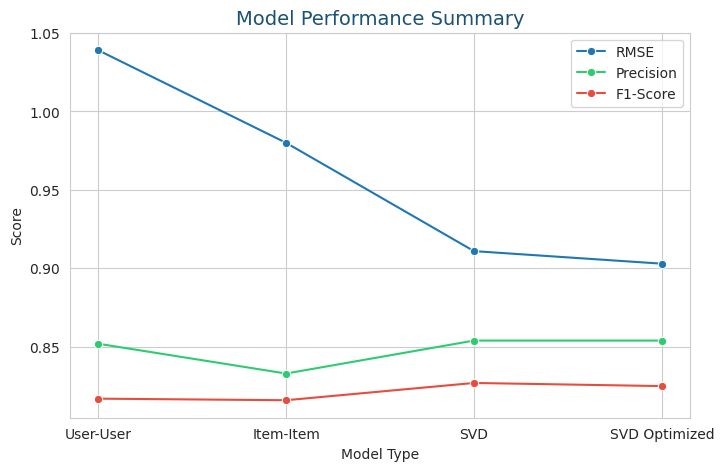

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model performance data
models = ['User-User', 'Item-Item', 'SVD', 'SVD Optimized']
rmse = [1.039, 0.980, 0.911, 0.903]
precision = [0.852, 0.833, 0.854, 0.854]
f1_score = [0.817, 0.816, 0.827, 0.825]

# Create a DataFrame for plotting
import pandas as pd
performance_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse,
    'Precision': precision,
    'F1-Score': f1_score
})

# Plot with Seaborn
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
sns.lineplot(data=performance_df, x='Model', y='RMSE', marker='o', color='#1f77b4', label='RMSE')
sns.lineplot(data=performance_df, x='Model', y='Precision', marker='o', color='#2ECC71', label='Precision')
sns.lineplot(data=performance_df, x='Model', y='F1-Score', marker='o', color='#E74C3C', label='F1-Score')

plt.title('Model Performance Summary', fontsize=14, color='#1A5276')
plt.xlabel('Model Type')
plt.ylabel('Score')
plt.legend()
plt.show()


> **Insight:** The optimized SVD model achieves the best balance of accuracy and precision, making it the ideal choice for production deployment.
